<a href="https://colab.research.google.com/github/Jorgi1-1/Prolog/blob/main/FC2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Chapter 18 – Reinforcement Learning**

# Setup

This project requires Python 3.7 or above:

In [ ]:
import sys

assert sys.version_info >= (3, 7)

And TensorFlow ≥ 2.8:

In [ ]:
from packaging import version
import tensorflow as tf

assert version.parse(tf.__version__) >= version.parse("2.8.0")

As we did in earlier chapters, let's define the default font sizes to make the figures prettier. We will also display some Matplotlib animations, and there are several possible options to do that: we will use the Javascript option.

In [ ]:
import matplotlib.animation
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
plt.rc('animation', html='jshtml')

And let's create the `images/rl` folder (if it doesn't already exist), and define the `save_fig()` function which is used through this notebook to save the figures in high-res for the book:

In [ ]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "rl"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

This chapter can be very slow without a GPU, so let's make sure there's one, or else issue a warning:

In [ ]:
if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. Neural nets can be very slow without a GPU.")
    if "google.colab" in sys.modules:
        print("Go to Runtime > Change runtime and select a GPU hardware "
              "accelerator.")
    if "kaggle_secrets" in sys.modules:
        print("Go to Settings > Accelerator and select GPU.")

No GPU was detected. Neural nets can be very slow without a GPU.
Go to Runtime > Change runtime and select a GPU hardware accelerator.


Let's install the Gymnasium library, which provides many environments for Reinforcement Learning. We'll also install the extra libraries needed for classic control environments (including CartPole, which we will use shortly), as well as for Box2D and Atari environments, which are needed for the exercises.

**Important notes:**
* OpenAI has handed over the maintenance and developmnent of the Gym library to the Farama foundation (see the [announcement](https://farama.org/Announcing-The-Farama-Foundation)), and the library was renamed to Gymnasium. It's a drop-in replacement for OpenAI Gym: you can just install `gymnasium` instead of `gym`, and `import gymnasium as gym`, and everything should work fine.
* by running the following cell, you accept the Atari ROM license.

In [ ]:
if "google.colab" in sys.modules or "kaggle_secrets" in sys.modules:
    %pip install -q -U gymnasium swig
    %pip install -q -U gymnasium[classic_control,box2d,atari,accept-rom-license]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 32.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 14.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.7/434.7 kB 33.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 60.7 MB/s eta 0:00:00


# Introduction to Gymnasium

In this notebook we will be using [gymnasium](https://github.com/Farama-Foundation/Gymnasium), a great toolkit for developing and comparing Reinforcement Learning algorithms. It provides many environments for your learning *agents* to interact with. Let's import Gym and make a new CartPole environment:

In [ ]:
import gymnasium as gym

env = gym.make("CartPole-v1", render_mode="rgb_array")

The CartPole (version 1) is a very simple environment composed of a cart that can move left or right, and pole placed vertically on top of it. The agent must move the cart left or right to keep the pole upright.

**Tip**: `gym.envs.registry` is a dictionary containing all available environments:

In [ ]:
# extra code – shows the first few environments
envs = gym.envs.registry
sorted(envs.keys())[:5] + ["..."]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['ALE/Adventure-ram-v5',
 'ALE/Adventure-v5',
 'ALE/AirRaid-ram-v5',
 'ALE/AirRaid-v5',
 'ALE/Alien-ram-v5',
 '...']

The registry values are environment specifications:

In [ ]:
# extra code – shows the specification for the CartPole-v1 environment
envs["CartPole-v1"]

EnvSpec(id='CartPole-v1', entry_point='gymnasium.envs.classic_control.cartpole:CartPoleEnv', reward_threshold=475.0, nondeterministic=False, max_episode_steps=500, order_enforce=True, autoreset=False, disable_env_checker=False, apply_api_compatibility=False, kwargs={}, namespace=None, name='CartPole', version=1, additional_wrappers=(), vector_entry_point='gymnasium.envs.classic_control.cartpole:CartPoleVectorEnv')

Let's initialize the environment by calling is `reset()` method. This returns an observation, as well as a dictionary that may contain extra information. Both are environment-specific.

In [ ]:
obs, info = env.reset(seed=42)
obs

array([ 0.0273956 , -0.00611216,  0.03585979,  0.0197368 ], dtype=float32)

In [ ]:
info

{}

In the case of the CartPole, each observation is a 1D NumPy array composed of 4 floats: they represent the cart's horizontal position, its velocity, the angle of the pole (0 = vertical), and the angular velocity.

An environment can be visualized by calling its `render()` method. If you set `render_mode` to `"rgb_array"` when creating the environment, then this will return a NumPy array.

In [ ]:
img = env.render()
img.shape  # height, width, channels (3 = Red, Green, Blue)

(400, 600, 3)

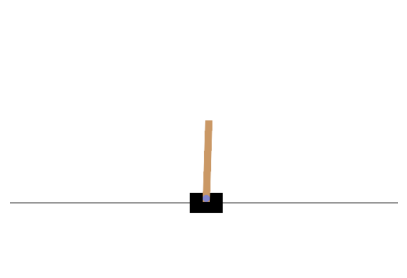

In [ ]:
# extra code – creates a little function to render and plot an environment

def plot_environment(env, figsize=(5, 4)):
    plt.figure(figsize=figsize)
    img = env.render()
    plt.imshow(img)
    plt.axis("off")
    return img

plot_environment(env)
plt.show()

Let's see how to interact with an environment. Your agent will need to select an action from an "action space" (the set of possible actions). Let's see what this environment's action space looks like:

In [ ]:
env.action_space

Discrete(2)

Yep, just two possible actions: accelerate towards the left (0) or towards the right (1).

Since the pole is leaning toward the right (`obs[2] > 0`), let's accelerate the cart toward the right:

In [ ]:
action = 1  # accelerate right
obs, reward, done, truncated, info = env.step(action)
obs

array([ 0.02727336,  0.18847767,  0.03625453, -0.26141977], dtype=float32)

Notice that the cart is now moving toward the right (`obs[1] > 0`). The pole is still tilted toward the right (`obs[2] > 0`), but its angular velocity is now negative (`obs[3] < 0`), so it will likely be tilted toward the left after the next step.

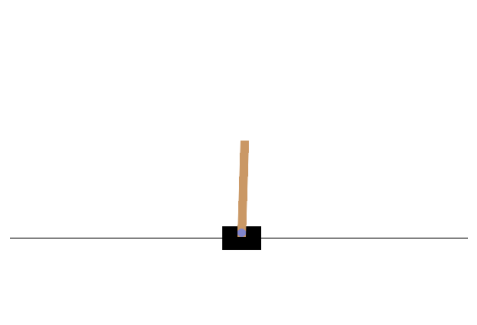

In [ ]:
# extra code – displays the environment
plot_environment(env)
save_fig("cart_pole_plot")
plt.show()

Looks like it's doing what we're telling it to do!

The environment also tells the agent how much reward it got during the last step:

In [ ]:
reward

1.0

When the game is over, the environment returns `done=True`. In this case, it's not over yet:

In [ ]:
done

False

Some environment wrappers may want to interrupt the environment early. For example, when a time limit is reached or when an object goes out of bounds. In this case, `truncated` will be set to `True`. In this case, it's not truncated yet:

In [ ]:
truncated

False

Finally, `info` is an environment-specific dictionary that can provide some extra information that you may find useful for debugging or for training. For example, in some games it may indicate how many lives the agent has.

In [ ]:
info

{}

The sequence of steps between the moment the environment is reset until it is done or truncated is called an "episode". At the end of an episode (i.e., when `step()` returns `done=True` or `truncated=True`), you should reset the environment before you continue to use it.

In [ ]:
if done or truncated:
    obs, info = env.reset()

Now how can we make the poll remain upright? We will need to define a _policy_ for that. This is the strategy that the agent will use to select an action at each step. It can use all the past actions and observations to decide what to do.

# A simple hard-coded policy

Let's hard code a simple strategy: if the pole is tilting to the left, then push the cart to the left, and _vice versa_. Let's see if that works:

In [ ]:
def basic_policy(obs):
    angle = obs[2]
    return 0 if angle < 0 else 1

totals = []
for episode in range(500):
    episode_rewards = 0
    obs, info = env.reset(seed=episode)
    for step in range(200):
        action = basic_policy(obs)
        obs, reward, done, truncated, info = env.step(action)
        episode_rewards += reward
        if done or truncated:
            break

    totals.append(episode_rewards)

In [ ]:
import numpy as np

np.mean(totals), np.std(totals), min(totals), max(totals)

(41.698, 8.389445512070509, 24.0, 63.0)

Well, as expected, this strategy is a bit too basic: the best it did was to keep the poll up for only 63 steps. This environment is considered solved when the agent keeps the poll up for 200 steps.

Let's visualize one episode. You can learn more about Matplotlib animations in the [Matplotlib tutorial notebook](tools_matplotlib.ipynb#Animations).

In [ ]:
# extra code – this cell displays an animation of one episode

def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = matplotlib.animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    plt.close()
    return anim

def show_one_episode(policy, n_max_steps=200, seed=42):
    frames = []
    env = gym.make("CartPole-v1", render_mode="rgb_array")
    np.random.seed(seed)
    obs, info = env.reset(seed=seed)
    for step in range(n_max_steps):
        frames.append(env.render())
        action = policy(obs)
        obs, reward, done, truncated, info = env.step(action)
        if done or truncated:
            break
    env.close()
    return plot_animation(frames)

show_one_episode(basic_policy)

Clearly the system is unstable and after just a few wobbles, the pole ends up too tilted: game over. We will need to be smarter than that!

# Neural Network Policies

Let's create a neural network that will take observations as inputs, and output the probabilities of actions to take for each observation. To choose an action, the network will estimate a probability for each action, then we will select an action randomly according to the estimated probabilities. In the case of the CartPole environment, there are just two possible actions (left or right), so we only need one output neuron: it will output the probability `p` of the action 0 (left), and of course the probability of action 1 (right) will be `1 - p`.

In [ ]:
import tensorflow as tf

tf.random.set_seed(42)  # extra code – ensures reproducibility on the CPU

model = tf.keras.Sequential([
    tf.keras.layers.Dense(5, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid"),
])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In this particular environment, the past actions and observations can safely be ignored, since each observation contains the environment's full state. If there were some hidden state then you may need to consider past actions and observations in order to try to infer the hidden state of the environment. For example, if the environment only revealed the position of the cart but not its velocity, you would have to consider not only the current observation but also the previous observation in order to estimate the current velocity. Another example is if the observations are noisy: you may want to use the past few observations to estimate the most likely current state. Our problem is thus as simple as can be: the current observation is noise-free and contains the environment's full state.

You may wonder why we plan to pick a random action based on the probability given by the policy network, rather than just picking the action with the highest probability. This approach lets the agent find the right balance between _exploring_ new actions and _exploiting_ the actions that are known to work well. Here's an analogy: suppose you go to a restaurant for the first time, and all the dishes look equally appealing so you randomly pick one. If it turns out to be good, you can increase the probability to order it next time, but you shouldn't increase that probability to 100%, or else you will never try out the other dishes, some of which may be even better than the one you tried.

Let's write a small policy function that will use the neural net to get the probability of moving left, then let's use it to run one episode:

In [ ]:
# extra code – a function that creates an animation for a given policy model

def pg_policy(obs):
    left_proba = model.predict(obs[np.newaxis], verbose=0)[0][0]
    return int(np.random.rand() > left_proba)

np.random.seed(42)
show_one_episode(pg_policy)

Yeah... pretty bad. The neural network will have to learn to do better. First let's see if it is capable of learning the basic policy we used earlier: go left if the pole is tilting left, and go right if it is tilting right.

Let's see if it can learn a better policy on its own. One that does not wobble as much.

# Policy Gradients

To train this neural network we will need to define the target probabilities **y**. If an action is good we should increase its probability, and conversely if it is bad we should reduce it. But how do we know whether an action is good or bad? The problem is that most actions have delayed effects, so when you win or lose points in an episode, it is not clear which actions contributed to this result: was it just the last action? Or the last 10? Or just one action 50 steps earlier? This is called the _credit assignment problem_.

The _Policy Gradients_ algorithm tackles this problem by first playing multiple episodes, then making the actions near positive rewards slightly more likely, while actions near negative rewards are made slightly less likely. First we play, then we go back and think about what we did.

Let's start by creating a function to play a single step using the model. We will also pretend for now that whatever action it takes is the right one, so we can compute the loss and its gradients. We will just save these gradients for now, and modify them later depending on how good or bad the action turned out to be.

In [ ]:
def play_one_step(env, obs, model, loss_fn):
    with tf.GradientTape() as tape:
        left_proba = model(obs[np.newaxis])
        action = (tf.random.uniform([1, 1]) > left_proba)
        y_target = tf.constant([[1.]]) - tf.cast(action, tf.float32)
        loss = tf.reduce_mean(loss_fn(y_target, left_proba))

    grads = tape.gradient(loss, model.trainable_variables)
    obs, reward, done, truncated, info = env.step(int(action))
    return obs, reward, done, truncated, grads

If `left_proba` is high, then `action` will most likely be `False` (since a random number uniformally sampled between 0 and 1 will probably not be greater than `left_proba`). And `False` means 0 when you cast it to a number, so `y_target` would be equal to 1 - 0 = 1. In other words, we set the target to 1, meaning we pretend that the probability of going left should have been 100% (so we took the right action).

Now let's create another function that will rely on the `play_one_step()` function to play multiple episodes, returning all the rewards and gradients, for each episode and each step:

In [ ]:
def play_multiple_episodes(env, n_episodes, n_max_steps, model, loss_fn):
    all_rewards = []
    all_grads = []
    for episode in range(n_episodes):
        current_rewards = []
        current_grads = []
        obs, info = env.reset()
        for step in range(n_max_steps):
            obs, reward, done, truncated, grads = play_one_step(
                env, obs, model, loss_fn)
            current_rewards.append(reward)
            current_grads.append(grads)
            if done or truncated:
                break

        all_rewards.append(current_rewards)
        all_grads.append(current_grads)

    return all_rewards, all_grads

The Policy Gradients algorithm uses the model to play the episode several times (e.g., 10 times), then it goes back and looks at all the rewards, discounts them and normalizes them. So let's create couple functions for that: the first will compute discounted rewards; the second will normalize the discounted rewards across many episodes.

In [ ]:
def discount_rewards(rewards, discount_factor):
    discounted = np.array(rewards)
    for step in range(len(rewards) - 2, -1, -1):
        discounted[step] += discounted[step + 1] * discount_factor
    return discounted

def discount_and_normalize_rewards(all_rewards, discount_factor):
    all_discounted_rewards = [discount_rewards(rewards, discount_factor)
                              for rewards in all_rewards]
    flat_rewards = np.concatenate(all_discounted_rewards)
    reward_mean = flat_rewards.mean()
    reward_std = flat_rewards.std()
    return [(discounted_rewards - reward_mean) / reward_std
            for discounted_rewards in all_discounted_rewards]

Say there were 3 actions, and after each action there was a reward: first 10, then 0, then -50. If we use a discount factor of 80%, then the 3rd action will get -50 (full credit for the last reward), but the 2nd action will only get -40 (80% credit for the last reward), and the 1st action will get 80% of -40 (-32) plus full credit for the first reward (+10), which leads to a discounted reward of -22:

In [ ]:
discount_rewards([10, 0, -50], discount_factor=0.8)

array([-22, -40, -50])

To normalize all discounted rewards across all episodes, we compute the mean and standard deviation of all the discounted rewards, and we subtract the mean from each discounted reward, and divide by the standard deviation:

In [ ]:
discount_and_normalize_rewards([[10, 0, -50], [10, 20]],
                               discount_factor=0.8)

[array([-0.28435071, -0.86597718, -1.18910299]),
 array([1.26665318, 1.0727777 ])]

In [ ]:
n_iterations = 100
n_episodes_per_update = 10
n_max_steps = 200
discount_factor = 0.95

In [ ]:
# extra code – let's create the neural net and reset the environment, for
#              reproducibility

tf.random.set_seed(42)

model = tf.keras.Sequential([
    tf.keras.layers.Dense(5, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid"),
])

obs, info = env.reset(seed=42)

In [ ]:
optimizer = tf.keras.optimizers.Nadam(learning_rate=0.01)
loss_fn = tf.keras.losses.binary_crossentropy

In [ ]:
for iteration in range(n_iterations):
    all_rewards, all_grads = play_multiple_episodes(
        env, n_episodes_per_update, n_max_steps, model, loss_fn)

    # extra code – displays some debug info during training
    total_rewards = sum(map(sum, all_rewards))
    print(f"\rIteration: {iteration + 1}/{n_iterations},"
          f" mean rewards: {total_rewards / n_episodes_per_update:.1f}", end="")

    all_final_rewards = discount_and_normalize_rewards(all_rewards,
                                                       discount_factor)
    all_mean_grads = []
    for var_index in range(len(model.trainable_variables)):
        mean_grads = tf.reduce_mean(
            [final_reward * all_grads[episode_index][step][var_index]
             for episode_index, final_rewards in enumerate(all_final_rewards)
                 for step, final_reward in enumerate(final_rewards)], axis=0)
        all_mean_grads.append(mean_grads)

    optimizer.apply_gradients(zip(all_mean_grads, model.trainable_variables))

/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/ops.py:291: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return int(self._numpy())


Iteration: 100/100, mean rewards: 53.9

In [ ]:
# extra code – displays the animation
np.random.seed(42)
show_one_episode(pg_policy)

# Q-learning

This code employs the Q-learning algorithm.
It initializes Q-values representing the expected future rewards for each state-action pair. During training, the agent interacts with the environment, updating Q-values based on the observed rewards and transitioning between states. The agent follows an epsilon-greedy policy, choosing random actions with probability epsilon and the action with the highest Q-value otherwise.

The code includes options for training the agent (`is_training=True`) or evaluating a pre-trained agent (`is_training=False`). During evaluation, the codde loads pre-existing Q-values from a file. The training loop continues until a satisfactory mean reward over recent episodes is achieved.

The key components of the code are the following:

1. **Q-value Update**: During training, Q-values are updated based on observed rewards and transitions between states. The Q-value update equation incorporates the reward received, the maximum expected future reward from the next state, and a learning rate and discount factor.

2. **Epsilon-Greedy Policy**: The agent follows an epsilon-greedy policy for action selection. With probability epsilon, a random action is chosen; otherwise, the action with the highest Q-value for the current state is selected.

3. **Training Loop**: The agent interacts with the environment, updating Q-values and transitioning between states until the termination condition is met.

Episode: 0  Rewards: 100.0
Episode: 0  Rewards: 200.0
Episode: 0  Rewards: 300.0
Episode: 0  Rewards: 400.0
Episode: 0  Rewards: 500.0
Episode: 0  Rewards: 600.0
Episode: 0  Rewards: 700.0
Episode: 0  Rewards: 800.0
Episode: 0  Rewards: 900.0
Episode: 0  Rewards: 1000.0
Episode: 0  Rewards: 1100.0
Episode: 0  Rewards: 1200.0
Episode: 0  Rewards: 1300.0
Episode: 0  Rewards: 1400.0
Episode: 0  Rewards: 1500.0
Episode: 0  Rewards: 1600.0
Episode: 0  Rewards: 1700.0
Episode: 0  Rewards: 1800.0
Episode: 0  Rewards: 1900.0
Episode: 0  Rewards: 2000.0
Episode: 0  Rewards: 2100.0
Episode: 0  Rewards: 2200.0
Episode: 0  Rewards: 2300.0
Episode: 0  Rewards: 2400.0
Episode: 0  Rewards: 2500.0
Episode: 0  Rewards: 2600.0
Episode: 0  Rewards: 2700.0
Episode: 0  Rewards: 2800.0
Episode: 0  Rewards: 2900.0
Episode: 0  Rewards: 3000.0
Episode: 0  Rewards: 3100.0
Episode: 0  Rewards: 3200.0
Episode: 0  Rewards: 3300.0
Episode: 0  Rewards: 3400.0
Episode: 0  Rewards: 3500.0
Episode: 0  Rewards: 3600.0
E

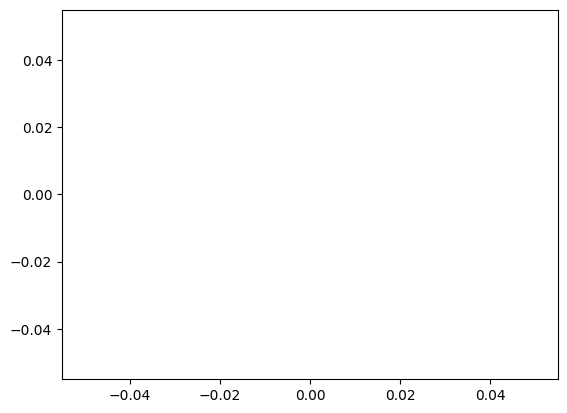

In [ ]:
#necessary imports
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import pickle

def run(is_training=True, render=False):
    # Create the environment
    env = gym.make('CartPole-v1', render_mode='human' if render else None)

    # Divide position, velocity, pole angle, and pole angular velocity into segments
    pos_space = np.linspace(-2.4, 2.4, 10)
    vel_space = np.linspace(-4, 4, 10)
    ang_space = np.linspace(-.2095, .2095, 10)
    ang_vel_space = np.linspace(-4, 4, 10)

    # Determines if the model is being trained or if it is using already existing data and acts accordingly.
    if(is_training):
        # Initialize Q-values if training
        q = np.zeros((len(pos_space)+1, len(vel_space)+1, len(ang_space)+1, len(ang_vel_space)+1, env.action_space.n)) # init a 11x11x11x11x2 array
    else:
        # Load Q-values from file if testing
        f = open('cartpole.pkl', 'rb')
        q = pickle.load(f)
        f.close()

    learning_rate_a = 0.1 # alpha or learning rate
    discount_factor_g = 0.99 # gamma or discount factor.

    epsilon = 1         # 1 = 100% random actions
    epsilon_decay_rate = 0.00001 # epsilon decay rate
    rng = np.random.default_rng()   # random number generator

    rewards_per_episode = []

    i = 0

    while(True):

        # Reset environment
        state = env.reset()[0]      # Starting position, starting velocity always 0
        state_p = np.digitize(state[0], pos_space)
        state_v = np.digitize(state[1], vel_space)
        state_a = np.digitize(state[2], ang_space)
        state_av = np.digitize(state[3], ang_vel_space)

        terminated = False          # True when reached goal

        rewards=0

        while(not terminated and rewards < 10000): # This will work until it reaches an acceptable number of rewards
            # Epsilon-greedy action selection
            if is_training and rng.random() < epsilon:
                # Choose random action  (0=go left, 1=go right)
                action = env.action_space.sample()
            else:
                action = np.argmax(q[state_p, state_v, state_a, state_av, :])

            # Perform action and observe new state and reward
            new_state,reward,terminated,_,_ = env.step(action)
            new_state_p = np.digitize(new_state[0], pos_space)
            new_state_v = np.digitize(new_state[1], vel_space)
            new_state_a = np.digitize(new_state[2], ang_space)
            new_state_av= np.digitize(new_state[3], ang_vel_space)

            if is_training:
                # Update Q-values
                q[state_p, state_v, state_a, state_av, action] = q[state_p, state_v, state_a, state_av, action] + learning_rate_a * (
                    reward + discount_factor_g*np.max(q[new_state_p, new_state_v, new_state_a, new_state_av,:]) - q[state_p, state_v, state_a, state_av, action]
                )

            # Update state and rewards
            state = new_state
            state_p = new_state_p
            state_v = new_state_v
            state_a = new_state_a
            state_av= new_state_av

            rewards+=reward

            if not is_training and rewards%100==0:
                print(f'Episode: {i}  Rewards: {rewards}')

        rewards_per_episode.append(rewards)
        mean_rewards = np.mean(rewards_per_episode[len(rewards_per_episode)-100:])

        if is_training and i%100==0:
            print(f'Episode: {i} {rewards}  Epsilon: {epsilon:0.2f}  Mean Rewards {mean_rewards:0.1f}')

        if mean_rewards>1000:
            break

        epsilon = max(epsilon - epsilon_decay_rate, 0)

        i+=1

    env.close()

    # Save Q table to file
    if is_training:
        f = open('cartpole.pkl','wb')
        pickle.dump(q, f)
        f.close()

    mean_rewards = []
    for t in range(i):
        mean_rewards.append(np.mean(rewards_per_episode[max(0, t-100):(t+1)]))
    plt.plot(mean_rewards)
    plt.savefig(f'cartpole.png')

if __name__ == '__main__':
     # run(is_training=True, render=False)

    run(is_training=False, render=True)

We can observe that the training and evaluation both work as expected; but the evaluation plot does not show up on Google Colab. To solve this isuse, one must run the script in a dedicated IDE.